In [1]:
%config Completer.use_jedi = False

import sys
sys.path.insert(1,'../')



# Pytorch related
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, transforms
from torch.utils import data as dt
from torchinfo import summary
import torchvision.models as pretrained_models
from alexnet_pytorch import AlexNet
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils import model_zoo
from torch.autograd import Variable



# Numpy, Matplotlib, Pandas, Sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import patches
import seaborn as sns
from sklearn import manifold
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score

from scipy.spatial import distance
from scipy.stats.stats import pearsonr
from scipy import stats

%matplotlib inline 


# python utilities
from itertools import combinations
import gc
import pickle
from tqdm import tqdm_notebook as tqdm
import copy
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import networkx as nx
import os
from IPython.display import Image
from IPython.core.debugger import set_trace
import collections
from functools import partial
import math
import time
import glob

from PIL import Image, ImageStat
from matplotlib.pyplot import imshow

# Extra imports
from lib.feature_extractor import FeatureExtractor
from lib.custom_dataset import Contour_Dataset
from lib.build_fe_ft_models import *
from lib.misc_functions import *
from lib.field_stim_functions import *




updated


# Hyperparameters

In [2]:
visual_diet_config={'root_directory':os.path.expanduser('/home/jovyan/work/Datasets/contour_integration/model-training/config_0/'),'get_B':[0,15,30,45,60,75],'get_D':[32],'get_A':[0],'get_numElements':[12]}



In [3]:
root_directory=visual_diet_config['root_directory']
get_B=visual_diet_config['get_B']
get_D=visual_diet_config['get_D']
get_A=visual_diet_config['get_A']
get_numElements=visual_diet_config['get_numElements']

In [4]:
img_dim=512

In [5]:
batch_size=32
num_workers=8
device = torch.device('cuda:'+'3')
# device = 'cpu'
device

device(type='cuda', index=3)

### Data Transforms

In [6]:
# normalize images using parameters from the training image set
data_transform = transforms.Compose([       
 transforms.Resize(img_dim),                   
 transforms.CenterCrop((img_dim,img_dim)),         
 transforms.ToTensor(),                    
 transforms.Normalize(                      
 mean=[0.485, 0.456, 0.406],                
 std=[0.229, 0.224, 0.225]                  
 )])

data_transform_without_norm = transforms.Compose([       
 transforms.Resize(img_dim),                   
 transforms.CenterCrop((img_dim,img_dim)),         
 transforms.ToTensor()                    
 ])

# Helper functions

In [7]:
def compute_diff_means(arr1, arr2):
    mean1 = np.mean(arr1)
    mean2 = np.mean(arr2)
    
    return (mean1 - mean2)

In [8]:
def compute_dprime_means(arr1, arr2):
    """
    Compute d' based on the difference of means divided by the pooled standard deviation.
    """
    mean1 = np.mean(arr1)
    mean2 = np.mean(arr2)
    
    var1 = np.var(arr1, ddof=1)  # ddof=1 for sample variance
    var2 = np.var(arr2, ddof=1)  # ddof=1 for sample variance
    
    # Calculate the pooled standard deviation
    pooled_std = np.sqrt((var1 + var2) / 2)
    
    # Compute d'
    d_prime = (mean1 - mean2) / pooled_std
    
    return d_prime

In [9]:
def compute_aprime_means(arr1, arr2):
    """
    Compute A' as the area under the ROC curve based on two input arrays.
    """
    # Combine the arrays and create corresponding labels
    combined = np.concatenate((arr1, arr2))
    labels = np.concatenate((np.ones(len(arr1)), np.zeros(len(arr2))))
    
    # Compute AUC
    a_prime = roc_auc_score(labels, combined)
    
    return a_prime

# Images

In [11]:
@interact(beta_val=(0,91,1),img_num=(0,100,1))
def get_data(beta_val=15,img_num=4):
    
    
    ### Show the image
    val_dataset_norm = Contour_Dataset(root=root_directory,transform=data_transform,train=False,get_B=[beta_val],get_D=get_D,get_A=get_A,get_numElements=get_numElements)
    val_loader_norm = torch.utils.data.DataLoader(dataset=val_dataset_norm, batch_size=batch_size, num_workers=num_workers, shuffle=False)

    val_dataset_without_norm = Contour_Dataset(root=root_directory,transform=data_transform_without_norm,train=False,get_B=[beta_val],get_D=get_D,get_A=get_A,get_numElements=get_numElements)
    val_loader_without_norm = torch.utils.data.DataLoader(dataset=val_dataset_without_norm, batch_size=batch_size, num_workers=num_workers, shuffle=False)


    
    
    a, b, d, alpha, nel, labels, record =next(iter(val_loader_norm))
    prep_img=torch.unsqueeze(a[img_num],0)
    print('Beta Val: ',b[img_num])
    print('Contour Present: ',labels[img_num])
    prep_img=prep_img.to(device)
    prep_img=Variable(prep_img,requires_grad=True)
    ## Plot the orginal image
    original_img=np.transpose(prep_img[0].detach().cpu().numpy(),(1,2,0))
    plt.figure(figsize=(10,8))
    plt.imshow(original_img)
    
    ## Plot the orginal unnormalized image
    plt.figure(figsize=(10,8))
    a_without_norm,b, d, alpha, nel, labels, record=next(iter(val_loader_without_norm))
    plt.imshow(np.transpose(torch.unsqueeze(a_without_norm[img_num],0)[0].numpy(),(1,2,0)))
    
    
    ## Plot the image with contour
    print(record[img_num])
    image_recorder_dict=torch.load(record[img_num])
    img_contour, img_control, img_contour_background, img_control_background=image_renderer(image_recorder_dict)
    display(blend(show_path(image_recorder_dict['path_points'], image_recorder_dict['path_centers'], imHeight=image_recorder_dict['image_height'], imWidth=image_recorder_dict['image_width']),img_contour_background,0.7))
    
    display(img_contour_background)
    display(img_contour)

    
    

interactive(children=(IntSlider(value=15, description='beta_val', max=91), IntSlider(value=4, description='img…

# Loading spliced model (just in cpu) example

In [11]:
# ## Sup regular 
# checkpoint=torch.load('../../dev/model_hub/regular_alexnet_broad/model_sup-regular_layer_avgpool_mode_finetune.pt')
# # checkpoint=torch.load('../../dev/model_hub/regular_alexnet/model_sup-regular_layer_avgpool_mode_frozen.pt')


# ## Resnet50 and Bagnet (9*9 and 33*33)
# # checkpoint=torch.load('../../dev/model_hub//bagnet_resnet/model_sup-resnet50_layer_avgpool_mode_finetune.pt')
# # checkpoint=torch.load('../../dev/model_hub/bagnet_resnet/model_sup-bagnet_layer_layer4_mode_finetune.pt')
# # checkpoint=torch.load('../../dev/model_hub/bagnet_resnet/model_sup-bagnet33_layer_layer4_mode_finetune.pt')


# ## Sup stylized
# # checkpoint=torch.load('../../dev/model_hub/stylized_alexnet/model_sup-stylized_layer_avgpool_mode_finetune.pt')
# # checkpoint=torch.load('../../dev/model_hub/stylized_alexnet/model_sup-stylized_layer_avgpool_mode_frozen.pt')


# ## Unsupervised
# # checkpoint=torch.load('../../dev/model_hub/unsupervised_alexnet/model_unsup-barlow_layer_backbone_mode_finetune.pt')
# # checkpoint=torch.load('../../dev/model_hub/unsupervised_alexnet/model_unsup-barlow_layer_backbone_mode_frozen.pt')

# ## Vision Transformer
# # checkpoint=torch.load('../../dev/model_hub/vision_transformer/model_vit-regular_layer_transformer-blocks-0-attn_mode_frozen.pt')





In [12]:
checkpoint=torch.load('../../dev/new_ccn23/alexnet_regimagenet_categ_finetune_broad/model_alexnet-pytorch-regim-categ_layer_avgpool_mode_finetune.pt')

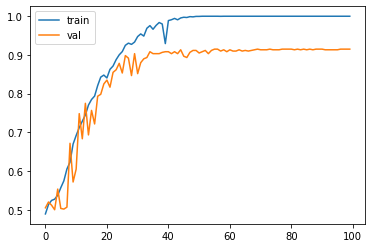

In [13]:
plt.plot(np.arange(len(checkpoint['metrics']['train_acc'])),checkpoint['metrics']['train_acc'],label='train')
plt.plot(np.arange(len(checkpoint['metrics']['val_acc'])),checkpoint['metrics']['val_acc'],label='val')
plt.legend()

In [14]:
loaded_spliced_model=SpliceModel(checkpoint['training_config']['base_model_name'],checkpoint['training_config']['layer_name'],fine_tune=checkpoint['training_config']['fine_tune'],device='cpu')
loaded_spliced_model.load_state_dict(checkpoint['model_state_dict'],strict=False)

_IncompatibleKeys(missing_keys=['base_model.classifier.1.weight', 'base_model.classifier.1.bias', 'base_model.classifier.4.weight', 'base_model.classifier.4.bias', 'base_model.classifier.6.weight', 'base_model.classifier.6.bias'], unexpected_keys=[])

# 1) 1 model, 1 image

In [15]:
model_file_paths=glob.glob('../../dev/new_ccn23/alexnet_regimagenet_categ_finetune_broad/*.pt')

In [16]:
@interact(beta_val=(0,91,1),img_num=(0,100,1))
def get_data(beta_val=15,img_num=4):
    
    
    ### Show the image
    val_dataset_norm = Contour_Dataset(root=root_directory,transform=data_transform,train=False,get_B=[beta_val],get_D=get_D,get_A=get_A,get_numElements=get_numElements)
    val_loader_norm = torch.utils.data.DataLoader(dataset=val_dataset_norm, batch_size=batch_size, num_workers=num_workers, shuffle=False)

    val_dataset_without_norm = Contour_Dataset(root=root_directory,transform=data_transform_without_norm,train=False,get_B=[beta_val],get_D=get_D,get_A=get_A,get_numElements=get_numElements)
    val_loader_without_norm = torch.utils.data.DataLoader(dataset=val_dataset_without_norm, batch_size=batch_size, num_workers=num_workers, shuffle=False)


    
    
    a, b, d, alpha, nel, labels, record =next(iter(val_loader_norm))
    prep_img=torch.unsqueeze(a[img_num],0)
    print('Beta Val: ',b[img_num])
    print('Contour Present: ',labels[img_num])
    prep_img=prep_img.to(device)
    prep_img=Variable(prep_img,requires_grad=True)
    
    ## Plot the orginal image
    original_img=np.transpose(prep_img[0].detach().cpu().numpy(),(1,2,0))
    plt.figure(figsize=(10,8))
    plt.imshow(original_img)
    # plt.close()
    
    ## Plot the orginal unnormalized image
    plt.figure(figsize=(10,8))
    a_without_norm,b, d, alpha, nel, labels, record=next(iter(val_loader_without_norm))
    plt.imshow(np.transpose(torch.unsqueeze(a_without_norm[img_num],0)[0].numpy(),(1,2,0)))
    
    plt.axis('off')
    plt.savefig('./dev/ccn_figures/poster/original_image.png', bbox_inches='tight',dpi=300) 
    # plt.close()
    
    
    @interact(file=model_file_paths)
    def vis_image(file,show_vis=False):
        

        if(show_vis):    
            checkpoint=torch.load(file)
            print('BASE MODEL IS',checkpoint['training_config']['base_model_name'])
            print('Final Val Accuracy is',checkpoint['metrics']['val_acc'][-1])

            plt.figure(figsize=(14,4))
            plt.subplot(1,2,1)
            plt.plot(np.arange(len(checkpoint['metrics']['train_acc'])),checkpoint['metrics']['train_acc'],label='train')
            plt.plot(np.arange(len(checkpoint['metrics']['val_acc'])),checkpoint['metrics']['val_acc'],label='val')
            plt.ylim(0.5,1.1)
            plt.legend()
            

            try:
                plt.subplot(1,2,2)
                plt.plot(np.arange(len(checkpoint['metrics']['optim_lr'])),checkpoint['metrics']['optim_lr'],label='lr')
                plt.legend()
                plt.show()
            except:
                pass



            # loaded_spliced_model=SpliceModel(checkpoint['training_config']['base_model_name'],checkpoint['training_config']['layer_name'],fine_tune=checkpoint['training_config']['fine_tune'],device='cpu')
            loaded_spliced_model=SpliceModel(checkpoint['training_config']['base_model_name'],checkpoint['training_config']['layer_name'],fine_tune=checkpoint['training_config']['fine_tune'],device=device)
            loaded_spliced_model.load_state_dict(checkpoint['model_state_dict'],strict=False)



            

            GBP = Spliced_GuidedBackprop(loaded_spliced_model,device)
            
            

            # Get gradients
            guided_grads = GBP.generate_gradients(prep_img, 1)

            
            # Gradients
            guided_grads_vis = guided_grads - guided_grads.min()
            guided_grads_vis /= guided_grads_vis.max()

            plt.figure(figsize=(10,8))
            plt.imshow(np.transpose(guided_grads_vis,(1,2,0)))
            # plt.close()


            # Grayscale Gradients
            grayscale_guided_grads = convert_to_grayscale(guided_grads)


            grayscale_guided_grads_vis = grayscale_guided_grads - grayscale_guided_grads.min()
            grayscale_guided_grads_vis /= grayscale_guided_grads_vis.max()

            plt.figure(figsize=(10,8))
            plt.imshow(np.squeeze(np.transpose(grayscale_guided_grads_vis,(1,2,0))),cmap='gray')
            plt.axis('off')
            plt.savefig('./dev/ccn_figures/poster/saliency_image.png',bbox_inches='tight', dpi=300) 
            # plt.close()




            ## Compute saliency maps
            print(grayscale_guided_grads_vis.shape)
            viz_image=grayscale_guided_grads_vis[0]
            
            
            ## Compute saliency scores
            mask_img_path_fg, mask_img_path_bg, list_gauss=mask_renderer(torch.load(record[img_num]),140)
            mask_img_path_fg=np.array(mask_img_path_fg)
            mask_img_path_bg=np.array(mask_img_path_bg)
            
            
            display(Image.fromarray(mask_img_path_fg))
            display(Image.fromarray(mask_img_path_bg))
            
            Image.fromarray(mask_img_path_fg).save("./dev/manuscript_figures/mask_fg.jpg", dpi=(300, 300))
            plt.show()
            
            
            Image.fromarray(mask_img_path_bg).save("./dev/manuscript_figures/mask_bg.jpg", dpi=(300, 300))
            plt.show()
            
            
            
            sns.distplot(viz_image[np.where(mask_img_path_fg==255)],label='distribution of fg')
            sns.distplot(viz_image[np.where(mask_img_path_bg==255)],label='distribution of bg')
            plt.title('Distribution of gradients')
            plt.legend()
            plt.show()


            
            
            saliency_score_diffmean=compute_diff_means(viz_image[np.where(mask_img_path_fg==255)],viz_image[np.where(mask_img_path_bg==255)])
            saliency_score_dprime=compute_dprime_means(viz_image[np.where(mask_img_path_fg==255)],viz_image[np.where(mask_img_path_bg==255)])
            saliency_score_aprime=compute_aprime_means(viz_image[np.where(mask_img_path_fg==255)],viz_image[np.where(mask_img_path_bg==255)])
            
            
            print('saliency_score_diffmean: \t', saliency_score_diffmean)
            print('saliency_score_diffmean: \t', saliency_score_dprime)
            print('saliency_score_diffmean: \t',saliency_score_aprime)
            
                        




interactive(children=(IntSlider(value=15, description='beta_val', max=91), IntSlider(value=4, description='img…

# 2) 1 model, All images

## Select the dataset

In [ ]:
val_dataset_norm = Contour_Dataset(root=root_directory,transform=data_transform,train=False,get_B=get_B,get_D=get_D,get_A=get_A,get_numElements=get_numElements)
val_loader_norm = torch.utils.data.DataLoader(dataset=val_dataset_norm, batch_size=batch_size, num_workers=num_workers, shuffle=False)
print(len(val_dataset_norm))

## Select the model

In [ ]:
model_file_paths=sorted(glob.glob('../../dev/new_ccn23/alexnet_regimagenet_categ_finetune_broad/*.pt'))

In [ ]:
for i,file in enumerate(model_file_paths):
    print(i,file)

In [ ]:
file=model_file_paths[0]
print(file)

## Computing the Saliency for all images

In [ ]:
def compute_saliency(prep_img,prep_recorder,file):
    prep_img=Variable(prep_img,requires_grad=True).to(device)


    # Model
    checkpoint=torch.load(file)
    
    # loaded_spliced_model=SpliceModel(checkpoint['training_config']['base_model_name'],checkpoint['training_config']['layer_name'],fine_tune=checkpoint['training_config']['fine_tune'],device='cpu')
    loaded_spliced_model=SpliceModel(checkpoint['training_config']['base_model_name'],checkpoint['training_config']['layer_name'],fine_tune=checkpoint['training_config']['fine_tune'],device=device)

    loaded_spliced_model.load_state_dict(checkpoint['model_state_dict'],strict=False)
    GBP = Spliced_GuidedBackprop(loaded_spliced_model,device)



    # Get gradients
    guided_grads = GBP.generate_gradients(prep_img, 1)
    # Gradients
    guided_grads_vis = guided_grads - guided_grads.min()
    guided_grads_vis /= guided_grads_vis.max()

    # Grayscale Gradients
    grayscale_guided_grads = convert_to_grayscale(guided_grads)
    grayscale_guided_grads_vis = grayscale_guided_grads - grayscale_guided_grads.min()
    grayscale_guided_grads_vis /= grayscale_guided_grads_vis.max()


    # Saliency Score
    viz_image=grayscale_guided_grads_vis[0]

    mask_img_path_fg, mask_img_path_bg, list_gauss=mask_renderer(torch.load(prep_recorder),140)
    mask_img_path_fg=np.array(mask_img_path_fg)
    mask_img_path_bg=np.array(mask_img_path_bg)
    
    
    
    saliency_score_diffmean=compute_diff_means(viz_image[np.where(mask_img_path_fg==255)],viz_image[np.where(mask_img_path_bg==255)])
    saliency_score_dprime=compute_dprime_means(viz_image[np.where(mask_img_path_fg==255)],viz_image[np.where(mask_img_path_bg==255)])
    saliency_score_aprime=compute_aprime_means(viz_image[np.where(mask_img_path_fg==255)],viz_image[np.where(mask_img_path_bg==255)])
    
    
    loaded_spliced_model=loaded_spliced_model.to('cpu')
    del GBP
    torch.cuda.empty_cache()
    gc.collect()
    
    return saliency_score_diffmean,saliency_score_dprime,saliency_score_aprime

## Running the loop - 1 model, All images

In [ ]:
all_saliency_score_diff=[]
all_saliency_score_dprime=[]
all_saliency_score_aprime=[]

all_betas=[]
all_labels=[]

for (a, b, d, alpha, nel, labels, record) in tqdm(val_loader_norm):
    for img_num in tqdm(range(a.shape[0]),disable=True):
        
        prep_img=torch.unsqueeze(a[img_num],0)
        prep_recorder=record[img_num]
        
        saliency_score_diffmean,saliency_score_dprime,saliency_score_aprime=compute_saliency(prep_img,prep_recorder,file)
        
        all_saliency_score_diff.append(saliency_score_diffmean)
        all_saliency_score_dprime.append(saliency_score_dprime)
        all_saliency_score_aprime.append(saliency_score_aprime)
        
        
        
    all_betas.append(b)
    all_labels.append(labels)

In [ ]:
all_betas=torch.cat(all_betas).numpy()
all_labels=torch.cat(all_labels).numpy()

In [ ]:
all_saliency_score_diff=np.array(all_saliency_score_diff)
all_saliency_score_dprime=np.array(all_saliency_score_dprime)
all_saliency_score_aprime=np.array(all_saliency_score_aprime)

## Visualizing the scores

In [ ]:
contour_present_pos=np.where(all_labels==1)[0]
contour_absent_pos=np.where(all_labels==0)[0]


In [ ]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
sns.distplot(all_saliency_score_diff[contour_present_pos],label='contour_present',color='green')
sns.distplot(all_saliency_score_diff[contour_absent_pos],label='contour_absent',color='gray')
plt.title('saliency_score_diffmean')
plt.legend()

plt.subplot(1,2,2)
sns.distplot(all_saliency_score_diff[contour_present_pos] - all_saliency_score_diff[contour_absent_pos],label='difference',color='k')
plt.title('Alignment Sensitivity')
plt.show()

plt.show()


# Perform the paired t-test
t_statistic, p_value = stats.ttest_rel(all_saliency_score_diff[contour_present_pos], all_saliency_score_diff[contour_absent_pos])
print(f"t-statistic: {t_statistic:.4f}")
print(f"p-value: {p_value:.4f}")



In [ ]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
sns.distplot(all_saliency_score_dprime[contour_present_pos],label='contour_present',color='green')
sns.distplot(all_saliency_score_dprime[contour_absent_pos],label='contour_absent',color='gray')
plt.title('saliency_score_dprime')
plt.legend()

plt.subplot(1,2,2)
sns.distplot(all_saliency_score_dprime[contour_present_pos] - all_saliency_score_dprime[contour_absent_pos],label='difference',color='k')
plt.title('Alignment Sensitivity')
plt.show()


# Perform the paired t-test
t_statistic, p_value = stats.ttest_rel(all_saliency_score_dprime[contour_present_pos], all_saliency_score_dprime[contour_absent_pos])
print(f"t-statistic: {t_statistic:.4f}")
print(f"p-value: {p_value:.4f}")

In [ ]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
sns.distplot(all_saliency_score_aprime[contour_present_pos],label='contour_present',color='green')
sns.distplot(all_saliency_score_aprime[contour_absent_pos],label='contour_absent',color='gray')
plt.title('saliency_score_aprime')
plt.legend()

plt.subplot(1,2,2)
sns.distplot(all_saliency_score_aprime[contour_present_pos] - all_saliency_score_aprime[contour_absent_pos],label='difference',color='k')
plt.title('Alignment Sensitivity')
plt.show()


plt.show()


# Perform the paired t-test
t_statistic, p_value = stats.ttest_rel(all_saliency_score_aprime[contour_present_pos], all_saliency_score_aprime[contour_absent_pos])
print(f"t-statistic: {t_statistic:.4f}")
print(f"p-value: {p_value:.4f}")

In [ ]:
plt.figure(figsize=(8,10))
# Scatter Plot with Connecting Lines
for x1, x2 in zip(all_saliency_score_aprime[contour_absent_pos], all_saliency_score_aprime[contour_present_pos]):
    plt.plot([x1, x2], [1, 2], 'ko-', markersize=8,alpha=0.09)
    

plt.yticks([1, 2], ['Contour absent', 'Contour present'])

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.savefig('./dev/manuscript_figures/foreground_sensitivity_contour_present_absent.png',bbox_inches='tight',dpi=300)
plt.show()

### Beta-wise saliency score

In [ ]:
unique_beta_vals=np.unique(all_betas)
unique_beta_saliency_mean=[]
unique_beta_saliency_std=[]



for i in unique_beta_vals:
    
    unique_beta_saliency_mean.append(np.mean(all_saliency_score[np.where(all_betas==i)[0]]))
    unique_beta_saliency_std.append(np.std(all_saliency_score[np.where(all_betas==i)[0]],ddof=1))

In [ ]:
unique_beta_saliency_mean

In [ ]:
unique_beta_saliency_std

In [ ]:
## ALREADY COMPUTED OVERALL
height=unique_beta_saliency_mean
error_bar=unique_beta_saliency_std

bars=unique_beta_vals
y_pos = np.arange(len(bars)) / 3.5
color=['green'] * len(unique_beta_vals)

plt.figure(figsize=(12,8))

plt.gca().bar(y_pos, height, yerr=error_bar, align='center', width=0.09, color=color, alpha=0.2, ecolor='gray', capsize=4)
plt.xticks(y_pos, bars,fontsize=15)
plt.yticks(fontsize=15)
plt.ylim(0.0,1.0)
plt.ylabel('Saliency Score',fontsize=25,labelpad=20)
plt.xlabel('Beta Values',fontsize=25,labelpad=20)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(True)
plt.gca().spines['bottom'].set_visible(True)

# 3) NEW-All models, All images

## Select the dataset

In [17]:
val_dataset_norm = Contour_Dataset(root=root_directory,transform=data_transform,train=False,get_B=get_B,get_D=get_D,get_A=get_A,get_numElements=get_numElements)
val_loader_norm = torch.utils.data.DataLoader(dataset=val_dataset_norm, batch_size=batch_size, num_workers=num_workers, shuffle=False)
print(len(val_dataset_norm))

600


## Select the model

In [18]:
model_file_paths=sorted(glob.glob('../../dev/new_ccn23/alexnet_regimagenet_categ_finetune_broad/*.pt'))

In [19]:
for i,file in enumerate(model_file_paths):
    print(i,file)

0 ../../dev/new_ccn23/alexnet_regimagenet_categ_finetune_broad/model_alexnet-pytorch-regim-categ_layer_avgpool_mode_finetune.pt
1 ../../dev/new_ccn23/alexnet_regimagenet_categ_finetune_broad/model_alexnet-pytorch-regim-categ_layer_classifier-0_mode_finetune.pt
2 ../../dev/new_ccn23/alexnet_regimagenet_categ_finetune_broad/model_alexnet-pytorch-regim-categ_layer_classifier-1_mode_finetune.pt
3 ../../dev/new_ccn23/alexnet_regimagenet_categ_finetune_broad/model_alexnet-pytorch-regim-categ_layer_classifier-2_mode_finetune.pt
4 ../../dev/new_ccn23/alexnet_regimagenet_categ_finetune_broad/model_alexnet-pytorch-regim-categ_layer_classifier-3_mode_finetune.pt
5 ../../dev/new_ccn23/alexnet_regimagenet_categ_finetune_broad/model_alexnet-pytorch-regim-categ_layer_classifier-4_mode_finetune.pt
6 ../../dev/new_ccn23/alexnet_regimagenet_categ_finetune_broad/model_alexnet-pytorch-regim-categ_layer_classifier-5_mode_finetune.pt
7 ../../dev/new_ccn23/alexnet_regimagenet_categ_finetune_broad/model_alexn

## Computing the Saliency for all images

In [20]:
def compute_saliency(prep_img,prep_recorder,file):
    prep_img=Variable(prep_img,requires_grad=True).to(device)


    # Model
    checkpoint=torch.load(file)
    
    # loaded_spliced_model=SpliceModel(checkpoint['training_config']['base_model_name'],checkpoint['training_config']['layer_name'],fine_tune=checkpoint['training_config']['fine_tune'],device='cpu')
    loaded_spliced_model=SpliceModel(checkpoint['training_config']['base_model_name'],checkpoint['training_config']['layer_name'],fine_tune=checkpoint['training_config']['fine_tune'],device=device)

    loaded_spliced_model.load_state_dict(checkpoint['model_state_dict'],strict=False)
    GBP = Spliced_GuidedBackprop(loaded_spliced_model,device)



    # Get gradients
    guided_grads = GBP.generate_gradients(prep_img, 1)
    # Gradients
    guided_grads_vis = guided_grads - guided_grads.min()
    guided_grads_vis /= guided_grads_vis.max()

    # Grayscale Gradients
    grayscale_guided_grads = convert_to_grayscale(guided_grads)
    grayscale_guided_grads_vis = grayscale_guided_grads - grayscale_guided_grads.min()
    grayscale_guided_grads_vis /= grayscale_guided_grads_vis.max()


    # Saliency Score
    viz_image=grayscale_guided_grads_vis[0]

    mask_img_path_fg, mask_img_path_bg, list_gauss=mask_renderer(torch.load(prep_recorder),140)
    mask_img_path_fg=np.array(mask_img_path_fg)
    mask_img_path_bg=np.array(mask_img_path_bg)
    
    
    
    saliency_score_diffmean=compute_diff_means(viz_image[np.where(mask_img_path_fg==255)],viz_image[np.where(mask_img_path_bg==255)])
    saliency_score_dprime=compute_dprime_means(viz_image[np.where(mask_img_path_fg==255)],viz_image[np.where(mask_img_path_bg==255)])
    saliency_score_aprime=compute_aprime_means(viz_image[np.where(mask_img_path_fg==255)],viz_image[np.where(mask_img_path_bg==255)])
    
    
    loaded_spliced_model=loaded_spliced_model.to('cpu')
    del GBP
    torch.cuda.empty_cache()
    gc.collect()
    
    return saliency_score_diffmean,saliency_score_dprime,saliency_score_aprime

## Running the loop - All models, All images

In [21]:
model_saliency_score_diff={}
model_saliency_score_dprime={}
model_saliency_score_aprime={}


for file in tqdm(model_file_paths):
    print(file)
    checkpoint=torch.load(file)
    
    model_saliency_score_diff[checkpoint['training_config']['layer_name']]=[]
    model_saliency_score_dprime[checkpoint['training_config']['layer_name']]=[]
    model_saliency_score_aprime[checkpoint['training_config']['layer_name']]=[]
    
    for (a, b, d, alpha, nel, labels, record) in tqdm(val_loader_norm,disable=True):
        
        
        for img_num in tqdm(range(a.shape[0]),disable=True):
            prep_img=torch.unsqueeze(a[img_num],0)
            prep_recorder=record[img_num]
            
            saliency_score_diffmean,saliency_score_dprime,saliency_score_aprime=compute_saliency(prep_img,prep_recorder,file)

            model_saliency_score_diff[checkpoint['training_config']['layer_name']].append(saliency_score_diffmean)
            model_saliency_score_dprime[checkpoint['training_config']['layer_name']].append(saliency_score_dprime)
            model_saliency_score_aprime[checkpoint['training_config']['layer_name']].append(saliency_score_aprime)
            
        
        
    model_saliency_score_diff[checkpoint['training_config']['layer_name']]=np.array(model_saliency_score_diff[checkpoint['training_config']['layer_name']])
    model_saliency_score_dprime[checkpoint['training_config']['layer_name']]=np.array(model_saliency_score_dprime[checkpoint['training_config']['layer_name']])
    model_saliency_score_aprime[checkpoint['training_config']['layer_name']]=np.array(model_saliency_score_aprime[checkpoint['training_config']['layer_name']])
    
    

  0%|          | 0/21 [00:00<?, ?it/s]

../../dev/new_ccn23/alexnet_regimagenet_categ_finetune_broad/model_alexnet-pytorch-regim-categ_layer_avgpool_mode_finetune.pt
../../dev/new_ccn23/alexnet_regimagenet_categ_finetune_broad/model_alexnet-pytorch-regim-categ_layer_classifier-0_mode_finetune.pt
../../dev/new_ccn23/alexnet_regimagenet_categ_finetune_broad/model_alexnet-pytorch-regim-categ_layer_classifier-1_mode_finetune.pt
../../dev/new_ccn23/alexnet_regimagenet_categ_finetune_broad/model_alexnet-pytorch-regim-categ_layer_classifier-2_mode_finetune.pt
../../dev/new_ccn23/alexnet_regimagenet_categ_finetune_broad/model_alexnet-pytorch-regim-categ_layer_classifier-3_mode_finetune.pt
../../dev/new_ccn23/alexnet_regimagenet_categ_finetune_broad/model_alexnet-pytorch-regim-categ_layer_classifier-4_mode_finetune.pt
../../dev/new_ccn23/alexnet_regimagenet_categ_finetune_broad/model_alexnet-pytorch-regim-categ_layer_classifier-5_mode_finetune.pt
../../dev/new_ccn23/alexnet_regimagenet_categ_finetune_broad/model_alexnet-pytorch-regim

In [23]:
all_betas=[]
all_labels=[]

for (a, b, d, alpha, nel, labels, record) in tqdm(val_loader_norm,disable=True):
    all_betas.append(b)
    all_labels.append(labels)

    
all_betas=torch.cat(all_betas).numpy()
all_labels=torch.cat(all_labels).numpy()

In [52]:
model_saliency_score_diff.keys()
model_saliency_score_dprime.keys()
model_saliency_score_aprime.keys()

dict_keys(['avgpool', 'classifier.0', 'classifier.1', 'classifier.2', 'classifier.3', 'classifier.4', 'classifier.5', 'classifier.6', 'features.0', 'features.10', 'features.11', 'features.12', 'features.1', 'features.2', 'features.3', 'features.4', 'features.5', 'features.6', 'features.7', 'features.8', 'features.9'])

## Visualizing the scores

In [27]:
contour_present_pos=np.where(all_labels==1)[0]
contour_absent_pos=np.where(all_labels==0)[0]


/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

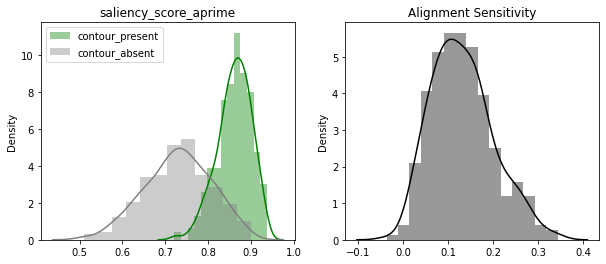

In [29]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
sns.distplot(model_saliency_score_aprime['avgpool'][contour_present_pos],label='contour_present',color='green')
sns.distplot(model_saliency_score_aprime['avgpool'][contour_absent_pos],label='contour_absent',color='gray')
plt.title('saliency_score_aprime')
plt.legend()

plt.subplot(1,2,2)
sns.distplot(model_saliency_score_aprime['avgpool'][contour_present_pos] - model_saliency_score_aprime['avgpool'][contour_absent_pos],label='difference',color='k')
plt.title('Alignment Sensitivity')
plt.show()


plt.show()


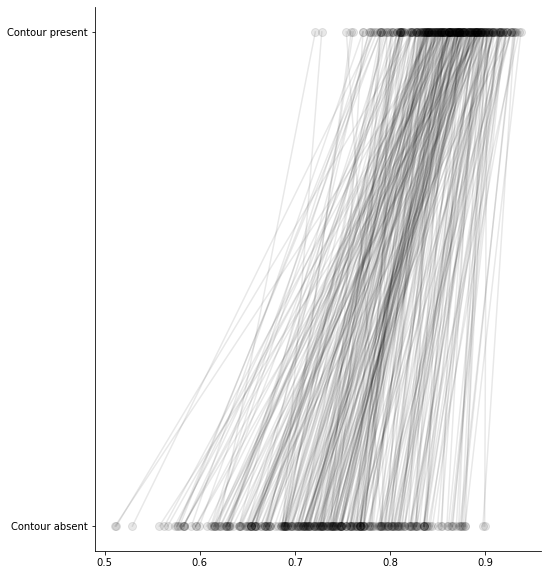

In [30]:
plt.figure(figsize=(8,10))
# Scatter Plot with Connecting Lines
for x1, x2 in zip(model_saliency_score_aprime['avgpool'][contour_absent_pos], model_saliency_score_aprime['avgpool'][contour_present_pos]):
    plt.plot([x1, x2], [1, 2], 'ko-', markersize=8,alpha=0.09)
    

plt.yticks([1, 2], ['Contour absent', 'Contour present'])

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.show()

### Visualzing all the models

In [45]:
def get_foreground_sensitivity_allmodels(sal_dict,list_layers,pos):
    mean_sal=[]
    std_sal=[]
    confint_sal=[]
    confint_lower=[]
    confint_upper=[]
    
    
    
    for i in range(len(list_layers)):
        layer=list_layers[i]
        
        
        if layer in sal_dict.keys():
            
            
            mean_sal.append(np.mean(sal_dict[layer][pos]))
            std_sal.append(np.std(sal_dict[layer][pos],ddof=1))
            
            
            
            confint_sal.append(1.96*(np.std(sal_dict[layer][pos],ddof=1) / np.sqrt(len(sal_dict[layer][pos]))))
            confint_lower.append(np.percentile(sal_dict[layer][pos], 2.5))
            confint_upper.append(np.percentile(sal_dict[layer][pos], 97.5))
            
    return mean_sal,std_sal,confint_sal,confint_lower,confint_upper


In [63]:
def get_alignment_sensitivity_allmodels(sal_dict,list_layers,present_pos,absent_pos):
    
    mean_sal=[]
    std_sal=[]
    confint_sal=[]
    confint_lower=[]
    confint_upper=[]
    
    
    
    for i in range(len(list_layers)):
        layer=list_layers[i]
        
        
        if layer in sal_dict.keys():
            
            
            diff_values=sal_dict[layer][present_pos] - sal_dict[layer][absent_pos]
            
            mean_sal.append(np.mean(diff_values))
            std_sal.append(np.std(diff_values))
            
            
            
            confint_sal.append(1.96*(np.std(diff_values) / np.sqrt(len(diff_values))))
            confint_lower.append(np.percentile(diff_values, 2.5))
            confint_upper.append(np.percentile(diff_values, 97.5))
            
    return mean_sal,std_sal,confint_sal,confint_lower,confint_upper


In [46]:
list_layers=['features_0',
 'features_1',
 'features_2',
 'features_3',
 'features_4',
 'features_5',
 'features_6',
 'features_7',
 'features_8',
 'features_9',
 'features_10',
 'features_11',
 'features_12',
 'avgpool',
 'classifier_0',
 'classifier_1',
 'classifier_2',
 'classifier_3',
 'classifier_4',
 'classifier_5',
 'classifier_6']

for i in range(len(list_layers)):
    list_layers[i]=list_layers[i].replace('_','.')

In [47]:
model_saliency_score_aprime['avgpool'].shape

(600,)

In [48]:
contour_present_pos=np.where(all_labels==1)[0]
contour_absent_pos=np.where(all_labels==0)[0]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  del sys.path[0]


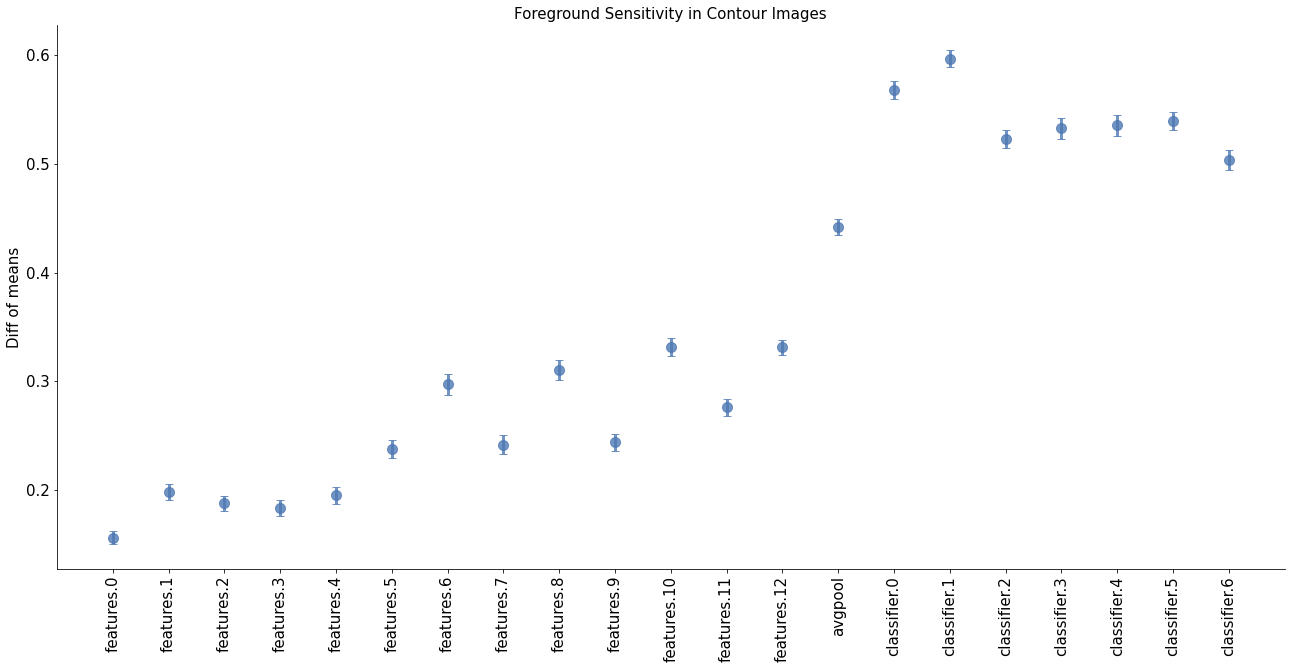

In [74]:
mean_sal,std_sal,confint_sal,confint_lower,confint_upper=get_foreground_sensitivity_allmodels(model_saliency_score_diff,list_layers,contour_present_pos)



plt.figure(figsize=(22,10))
color_or_finetune=(78/255,121/255,180/255)
spacing_x=2
error_bar_width=3
error_bar_cap=4

plt.errorbar(np.arange(len(mean_sal)) * spacing_x, mean_sal, yerr=confint_sal, 
             capsize=error_bar_cap,elinewidth=error_bar_width,fmt='o',marker='o', color=color_or_finetune, markersize=10, 
             label='or finetune', alpha=0.8)





plt.xticks(np.arange(len(mean_sal)) * spacing_x,list_layers,rotation=90,fontsize=15)
plt.yticks(fontsize=15) 


plt.ylabel('Diff of means',fontsize=15)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.title('Foreground Sensitivity in Contour Images',fontsize=15)

plt.savefig('./dev/manuscript_figures/foreground_sensitivity_allmodel_diffmean.png', format='png', dpi=600)

plt.show()
    
    
    
    

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  del sys.path[0]


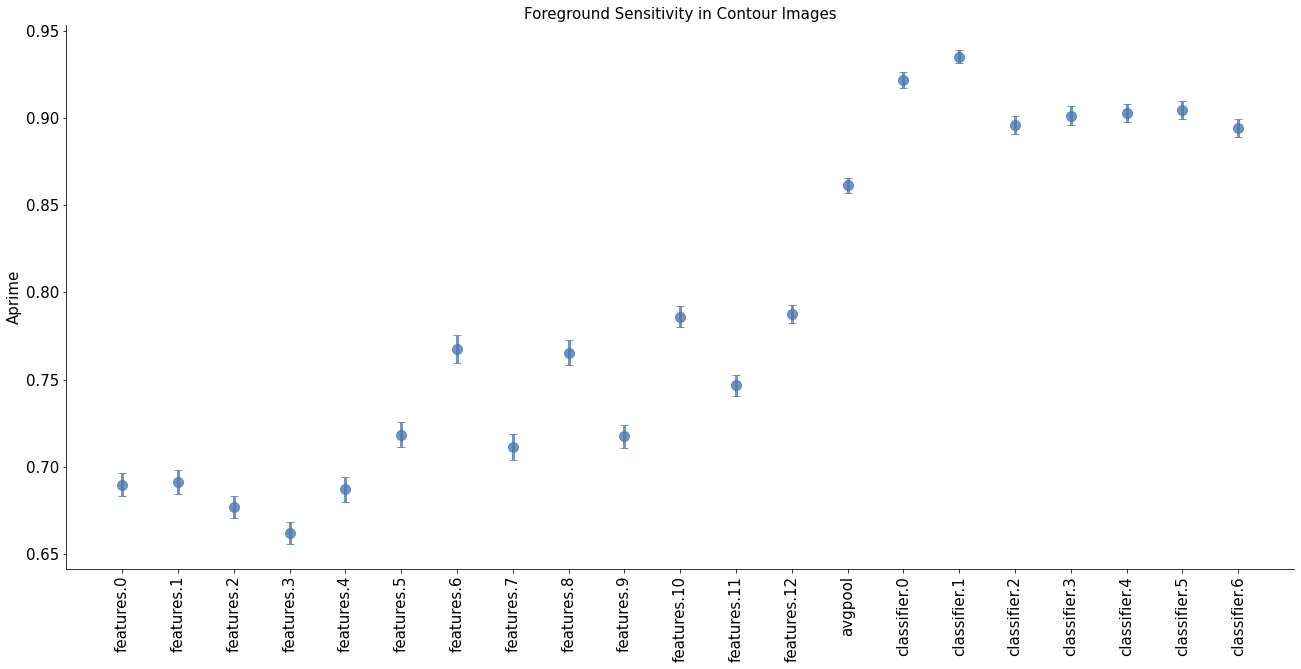

In [75]:
mean_sal,std_sal,confint_sal,confint_lower,confint_upper=get_foreground_sensitivity_allmodels(model_saliency_score_aprime,list_layers,contour_present_pos)



plt.figure(figsize=(22,10))
color_or_finetune=(78/255,121/255,180/255)
spacing_x=2
error_bar_width=3
error_bar_cap=4

plt.errorbar(np.arange(len(mean_sal)) * spacing_x, mean_sal, yerr=confint_sal, 
             capsize=error_bar_cap,elinewidth=error_bar_width,fmt='o',marker='o', color=color_or_finetune, markersize=10, 
             label='or finetune', alpha=0.8)





plt.xticks(np.arange(len(mean_sal)) * spacing_x,list_layers,rotation=90,fontsize=15)
plt.yticks(fontsize=15) 


plt.ylabel('Aprime',fontsize=15)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.title('Foreground Sensitivity in Contour Images',fontsize=15)

plt.savefig('./dev/manuscript_figures/foreground_sensitivity_allmodel_aprime.png', format='png', dpi=600)
plt.show()
    
    
    
    

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  # This is added back by InteractiveShellApp.init_path()


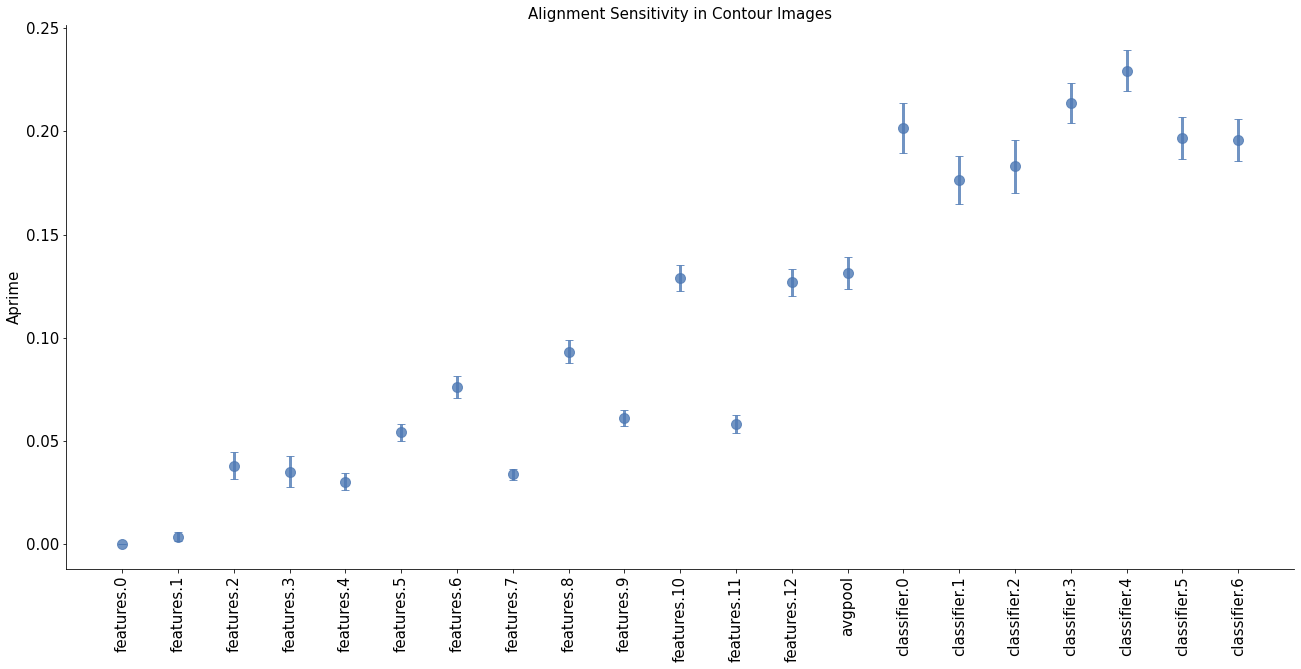

In [76]:
mean_sal,std_sal,confint_sal,confint_lower,confint_upper=get_alignment_sensitivity_allmodels(model_saliency_score_aprime,list_layers,contour_present_pos,contour_absent_pos)

plt.figure(figsize=(22,10))
color_or_finetune=(78/255,121/255,180/255)
spacing_x=2
error_bar_width=3
error_bar_cap=4

plt.errorbar(np.arange(len(mean_sal)) * spacing_x, mean_sal, yerr=confint_sal, 
             capsize=error_bar_cap,elinewidth=error_bar_width,fmt='o',marker='o', color=color_or_finetune, markersize=10, 
             label='or finetune', alpha=0.8)





plt.xticks(np.arange(len(mean_sal)) * spacing_x,list_layers,rotation=90,fontsize=15)
plt.yticks(fontsize=15) 


plt.ylabel('Aprime',fontsize=15)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.title('Alignment Sensitivity in Contour Images',fontsize=15)

plt.savefig('./dev/manuscript_figures/alignment_sensitivity_allmodel_aprime.png', format='png', dpi=600)
plt.show()
    


# Analyze signal detection

In [ ]:
val_dataset_norm = Contour_Dataset(root=root_directory,transform=data_transform,train=False,get_B=[0,15,30,45,60,75],get_D=get_D,get_alpha=get_alpha)
val_loader_norm = torch.utils.data.DataLoader(dataset=val_dataset_norm, batch_size=100, num_workers=num_workers, shuffle=False)

In [ ]:
sup_regular_finetune_files = glob.glob("../../dev/updated_finetuned_models/model_sup-regular_*finetune.pt")
# sup_regular_finetune_files = glob.glob("../../dev/updated_finetuned_models/model_sup-regular_*frozen.pt")

In [ ]:
for i,file in enumerate(sup_regular_finetune_files):
    print(i,file)

In [ ]:
file=sup_regular_finetune_files[6]

In [ ]:
file

In [ ]:
checkpoint=torch.load(file)

loaded_spliced_model=SpliceModel(checkpoint['training_config']['base_model_name'],checkpoint['training_config']['layer_name'],fine_tune=checkpoint['training_config']['fine_tune'],device=device)

loaded_spliced_model.load_state_dict(checkpoint['model_state_dict'],strict=False)

In [ ]:
softmax_layer=nn.Softmax(dim=1)

In [ ]:
all_betas=[]
all_labels=[]
all_outputs=[]
all_preds=[]

for (a,b, c, image_recorder) in val_loader_norm:
    a=a.to(device)
    output=loaded_spliced_model.forward(a).detach().cpu()
    _, preds = torch.max(output, 1)
        
    all_preds.append(preds)
    all_outputs.append(softmax_layer(output))
    # all_outputs.append(output)
    
    all_betas.append(b)
    all_labels.append(c)

In [ ]:
all_betas=torch.cat(all_betas).numpy()
all_labels=torch.cat(all_labels).numpy()
all_preds=torch.cat(all_preds).numpy()
all_outputs=torch.cat(all_outputs).numpy()


In [ ]:
all_betas.shape

In [ ]:
unique_beta_vals=np.unique(all_betas)
unique_beta_signal=[]
unique_beta_acc=[]


for i in unique_beta_vals:
    
    acc=np.mean(all_labels[np.where(all_betas==i)[0]] == all_preds[np.where(all_betas==i)[0]])
    unique_beta_acc.append(acc)
    
    ## signal
    # t=all_outputs[np.where((all_labels==1) & (all_betas==i))[0]]
    t=all_outputs[np.where(all_betas==i)[0]]
    
    unique_beta_signal.append(np.mean(t[:,1] - t[:,0]))

In [ ]:
unique_beta_vals

In [ ]:
unique_beta_acc

In [ ]:
unique_beta_signal

#### Comparing with D.F and A.H data

In [ ]:
human_data_beta_val=[15,30,45,60,75]
human_data_beta_acc=[0.9897868561278863, 0.8716696269982238, 0.8579040852575489, 0.6096802841918294, 0.5648312611012434]

In [ ]:
unique_beta_acc

In [ ]:
np.corrcoef(unique_beta_signal[1:],human_data_beta_acc)

In [ ]:
np.corrcoef(unique_beta_acc[1:],human_data_beta_acc)

In [ ]:
plt.figure(figsize=(17,15))


plt.plot(human_data_beta_val,human_data_beta_acc,marker='.',markersize=10,label='human',color='k',linestyle='dashdot',linewidth=4)
    
    
xtick_positions=[0,15,30,45,60,75]
plt.xticks(ticks=xtick_positions)
for i in xtick_positions:
    plt.axvline(x=i,linestyle='--',color='k',alpha=0.3)

plt.axhline(y=0.5,linestyle='dashed',color='red',label='chance')
plt.ylim(0.4,1.05)
plt.xlabel('Beta values',fontsize=15)
plt.ylabel('Accuracy',fontsize=15)

# plt.legend()
plt.legend(loc=1)

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.show()

# Analyze other images [Gaboriforms]

In [ ]:
sup_regular_finetune_files = glob.glob("../../dev/updated_finetuned_models/model_sup-regular_*finetune.pt")
# sup_regular_finetune_files = glob.glob("../../dev/updated_finetuned_models/model_sup-regular_*frozen.pt")

In [ ]:
for i,file in enumerate(sup_regular_finetune_files):
    print(i,file)

In [ ]:
file=sup_regular_finetune_files[6]

In [ ]:
file

In [ ]:
checkpoint=torch.load(file)

loaded_spliced_model=SpliceModel(checkpoint['training_config']['base_model_name'],checkpoint['training_config']['layer_name'],fine_tune=checkpoint['training_config']['fine_tune'],device=device)

loaded_spliced_model.load_state_dict(checkpoint['model_state_dict'],strict=False)

In [ ]:
# normalize images using parameters from the training image set
just_vis_transform= transforms.Compose([       
 transforms.Resize(256),transforms.Pad(128),
 transforms.CenterCrop((512,512)),transforms.ToTensor()])

In [ ]:
img=Image.open('./dev/random_images/gaboriforms/sketch_P30_A_helvetica.png').convert('RGB')

plt.imshow(np.array(img))
plt.show()

plt.imshow(np.transpose(just_vis_transform(img).numpy(),(1,2,0)))

In [ ]:
# normalize images using parameters from the training image set
gaboriform_transform= transforms.Compose([       
 transforms.Resize(256),transforms.Pad(128),
 transforms.CenterCrop((512,512)),         
 transforms.ToTensor(),                    
 transforms.Normalize(                      
 mean=[0.485, 0.456, 0.406],                
 std=[0.229, 0.224, 0.225])])

In [ ]:
# img=Image.open('./dev/random_images/gaboriforms/sketch_Random_A_helvetica.png').convert('RGB')
img=Image.open('./dev/random_images/gaboriforms/sketch_P30_A_helvetica.png').convert('RGB')
img=gaboriform_transform(img)
img=img.to(device)
img=torch.unsqueeze(img,0)
img.shape

In [ ]:
@interact
def get_data():
    
    
    img=Image.open('./dev/random_images/gaboriforms/sketch_P30_A_helvetica.png').convert('RGB')
    # img=Image.open('./dev/random_images/gaboriforms/sketch_P10_A_helvetica.png').convert('RGB')
    # img=Image.open('./dev/random_images/gaboriforms/sketch_N10_A_helvetica.png').convert('RGB')
    # img=Image.open('./dev/random_images/gaboriforms/sketch_Base_A_helvetica.png').convert('RGB')
    
    plt.imshow(np.array(img))
    plt.show()
    
    img=gaboriform_transform(img)
    
    
    img=img.to(device)
    img=torch.unsqueeze(img,0)
    prep_img=Variable(img,requires_grad=True)
    
    
    
    
    
    @interact(file=sup_regular_finetune_files)
    def vis_image(file=sup_regular_finetune_files[6],show_vis=True):
        
        if(show_vis):
            
            checkpoint=torch.load(file)
             
            # checkpoint=torch.load('./dev/testing_vis_models/ft_simple-readout/hidden_1_lr_0.0001/model_sup-regular_layer_avgpool_mode_finetune.pt')
            
            print('loaded model')
            plt.figure(figsize=(14,4))
            plt.subplot(1,2,1)
            plt.plot(np.arange(len(checkpoint['metrics']['train_acc'])),checkpoint['metrics']['train_acc'],label='train')
            plt.plot(np.arange(len(checkpoint['metrics']['val_acc'])),checkpoint['metrics']['val_acc'],label='val')
            plt.ylim(0.4,1.1)
            plt.legend()
            
            try:
                plt.subplot(1,2,2)
                plt.plot(np.arange(len(checkpoint['metrics']['optim_lr'])),checkpoint['metrics']['optim_lr'],label='lr')
                plt.legend()
                plt.show()
            except:
                pass
        
        
        
            loaded_spliced_model=SpliceModel(checkpoint['training_config']['base_model_name'],checkpoint['training_config']['layer_name'],fine_tune=checkpoint['training_config']['fine_tune'],device=device)
            loaded_spliced_model.load_state_dict(checkpoint['model_state_dict'],strict=False)
            output=loaded_spliced_model.forward(img).detach().cpu()
            print(output)
            

            GBP = N_GuidedBackprop(loaded_spliced_model,device=device)


            # Get gradients
            guided_grads = GBP.generate_gradients(prep_img, 1)

            # Gradients
            guided_grads_vis = guided_grads - guided_grads.min()
            guided_grads_vis /= guided_grads_vis.max()

            plt.figure(figsize=(10,8))
            plt.imshow(np.transpose(guided_grads_vis,(1,2,0)))


            # Grayscale Gradients
            grayscale_guided_grads = convert_to_grayscale(guided_grads)


            grayscale_guided_grads_vis = grayscale_guided_grads - grayscale_guided_grads.min()
            grayscale_guided_grads_vis /= grayscale_guided_grads_vis.max()

            plt.figure(figsize=(10,8))
            plt.imshow(np.squeeze(np.transpose(grayscale_guided_grads_vis,(1,2,0))),cmap='gray')
            plt.axis('off')
        



In [ ]:
point_p10 = np.array([-33.1276,  30.6098])
point_n10 = np.array([-31.4670,  29.0349])
point_p30 = np.array([-47.4325,  45.2123])
 
# calculating Euclidean distance
# using linalg.norm()
print(np.linalg.norm(point_p10 - point_n10))
print(np.linalg.norm(point_p10 - point_p30))

In [ ]:
point_p10 = np.array([-14.3679,  13.7414])
point_n10 = np.array([-14.2654,  14.0088])
point_p30 = np.array([-24.5802,  23.7775])
 
# calculating Euclidean distance
# using linalg.norm()
print(np.linalg.norm(point_p10 - point_n10))
print(np.linalg.norm(point_p10 - point_p30))

# Workspace for testing backward passes

# Testing forward and backward fucntion on a toy model

In [ ]:
from torchinfo import summary

In [ ]:
# base_model=get_base_model('sup_regular')
base_model=Net()

In [ ]:
# view_img=torch.randn(2,3,512,512)
view_img=torch.randn(1,3,32,32)

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.relu1=nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.relu2=nn.ReLU()
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(self.relu1(self.conv1(x)))
        x = self.pool(self.relu2(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

In [ ]:
# summary(base_model,(1,3,512,512), device='cpu', verbose=0)
summary(base_model,(1,3,32,32), device='cpu', verbose=0)

In [ ]:
base_model

In [ ]:
for name,module in base_model.named_modules():
    print(name)

# Trying a forward pass - This works

In [ ]:
# base_model=get_base_model('sup_regular')
# view_img=torch.randn(2,3,512,512)

base_model=Net()
view_img=torch.randn(1,3,32,32)

In [ ]:
forward_activations_in=[]
forward_activations_out=[]

In [ ]:
def forward_hook_function(module, ten_in, ten_out):
    forward_activations_in.append(ten_in)
    forward_activations_out.append(ten_out)

In [ ]:
for name,module in base_model.named_modules():
    if(name=='relu1'):
        module.register_forward_hook(forward_hook_function)
        

In [ ]:
print(forward_activations_in)
print(forward_activations_out)

In [ ]:
output=base_model(view_img)
output.shape

In [ ]:
print(forward_activations_in[0][0].shape)
print(forward_activations_out[0].shape)

# Trying a backward pass - This is hard lol

In [ ]:
# base_model=get_base_model('sup_regular')
# view_img=torch.randn(2,3,512,512)

base_model=Net()
view_img=torch.randn(1,3,32,32)

In [ ]:
backward_gradients_in=[]
backward_gradients_out=[]

In [ ]:
def backward_hook_function(module, grad_in, grad_out):
    backward_gradients_in.append(grad_in)
    backward_gradients_out.append(grad_out)

In [ ]:
for name,module in base_model.named_modules():
    if(name=='conv2'):
        module.register_backward_hook(backward_hook_function)
        

In [ ]:
backward_gradients_in

In [ ]:
output=base_model(view_img)
output.shape

In [ ]:
backward_gradients_in

In [ ]:
torch.mean(output).backward()

In [ ]:
len(backward_gradients_in[0])

In [ ]:
len(backward_gradients_out[0])

In [ ]:
for i in range(len(backward_gradients_in[0])):
    print(backward_gradients_in[0][i].shape)

In [ ]:
for i in range(len(backward_gradients_out[0])):
    print(backward_gradients_out[0][i].shape)

# Combining the two

In [ ]:
# base_model=get_base_model('sup_regular')
# view_img=torch.randn(2,3,512,512)

base_model=Net()
view_img=torch.randn(1,3,32,32)

In [ ]:
forward_activations_in=[]
forward_activations_out=[]

In [ ]:
backward_gradients_in=[]
backward_gradients_out=[]

In [ ]:
def backward_hook_function(module, grad_in, grad_out):
    backward_gradients_in.append(grad_in)
    backward_gradients_out.append(grad_out)

In [ ]:
def forward_hook_function(module, ten_in, ten_out):
    forward_activations_in.append(ten_in)
    forward_activations_out.append(ten_out)

In [ ]:
for name,module in base_model.named_modules():
    if(name=='relu2'):
        module.register_backward_hook(backward_hook_function)
        module.register_forward_hook(forward_hook_function)
        

In [ ]:
output=base_model(view_img)
torch.mean(output).backward()

In [ ]:
for i in range(len(backward_gradients_in[0])):
    print(backward_gradients_in[0][i].shape)

for i in range(len(backward_gradients_out[0])):
    print(backward_gradients_out[0][i].shape)

In [ ]:
print(forward_activations_in[0][0].shape)
print(forward_activations_out[0].shape)

# Testing the grad_in and grad_out for relu layers

In [ ]:
# base_model=get_base_model('sup_regular')
# view_img=torch.randn(2,3,512,512)

base_model=Net()
view_img=torch.randn(1,3,32,32)

In [ ]:
forward_activations_in=[]
forward_activations_out=[]

In [ ]:
backward_gradients_in=[]
backward_gradients_out=[]

In [ ]:
def backward_hook_function(module, grad_in, grad_out):
    backward_gradients_in.append(grad_in)
    backward_gradients_out.append(grad_out)

In [ ]:
def forward_hook_function(module, ten_in, ten_out):
    forward_activations_in.append(ten_in)
    forward_activations_out.append(ten_out)

In [ ]:
for name,module in base_model.named_modules():
    if(name=='relu2'):
        module.register_backward_hook(backward_hook_function)
        module.register_forward_hook(forward_hook_function)
        

In [ ]:
output=base_model(view_img)
torch.mean(output).backward()

In [ ]:
for i in range(len(backward_gradients_in[0])):
    print(backward_gradients_in[0][i].shape)

for i in range(len(backward_gradients_out[0])):
    print(backward_gradients_out[0][i].shape)

In [ ]:
print(forward_activations_in[0][0].shape)
print(forward_activations_out[0].shape)

In [ ]:
grad_in=backward_gradients_in[0][0]

In [ ]:
grad_out=backward_gradients_out[0][0]

In [ ]:
tensor_in=forward_activations_in[0][0]

In [ ]:
tensor_out=forward_activations_out[0]

In [ ]:
sns.distplot(grad_in.numpy())

In [ ]:
sns.distplot(torch.clamp(grad_in,min=0.0).numpy())

In [ ]:
torch.equal(grad_out,grad_in)

In [ ]:
tensor_out.shape

In [ ]:
grad_out.shape

In [ ]:
positions=tensor_out

positions[positions>0]=1.0

torch.equal(grad_out * positions, grad_in)

### Hence to propagate negative gradients, just take grad_in and pass the positive values

In [ ]:
new_grad_in=torch.clamp(grad_in,min=0.0)